## Processing the Input dataset from chEMBL

In [15]:
import pandas as pd
# List of cathepsins
cathepsins = ["B", "S", "D", "K"]

### Checking Columns

In [16]:
for cat in cathepsins:
# Load the combined file
    combined_file = f"./chEMBL_initial/cat{cat}_chEMBL.tsv"  # Replace with the path to your combined .tsv file
    df = pd.read_csv(combined_file, sep="\t")
    # Get column names as a list
    column_names = df.columns.tolist()
    # Print the column names
    print(column_names)


['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase', 'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment', 'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE', 'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate', 'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID', 'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID', 'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction', 'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation', 'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type', 'Document ChEMBL ID', 'Source ID', 'Source Description', 'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties', 'Action Type', 'Standard Text Value', 'Value']
['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase', 'Molecular Weight', '#RO5 Vi

### Selecting main columns

In [17]:
columns_to_keep = [ 
    'Smiles','Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'Assay Description',
]

for cat in cathepsins:
    df = pd.read_csv(f"./chEMBL_initial/cat{cat}_chEMBL.tsv", sep='\t')
    df_filtered = df[columns_to_keep]
    df_filtered.to_csv(f"./Intermediate_chEMBL/CAT {cat}/Limited_Columns_data_{cat}.tsv", sep='\t', index=False)
    print(f"Processed ./chEMBL_initial/cat{cat}_chEMBL.tsv and saved to ./Intermediate_chEMBL/CAT {cat}/Limited_Columns_data_{cat}.tsv")



Processed ./chEMBL_initial/catB_chEMBL.tsv and saved to ./Intermediate_chEMBL/CAT B/Limited_Columns_data_B.tsv
Processed ./chEMBL_initial/catS_chEMBL.tsv and saved to ./Intermediate_chEMBL/CAT S/Limited_Columns_data_S.tsv
Processed ./chEMBL_initial/catD_chEMBL.tsv and saved to ./Intermediate_chEMBL/CAT D/Limited_Columns_data_D.tsv
Processed ./chEMBL_initial/catK_chEMBL.tsv and saved to ./Intermediate_chEMBL/CAT K/Limited_Columns_data_K.tsv


### Selecting human and required cathepsin (B D S K)

In [18]:
# Function to filter rows based on the presence of both "human" and "cathepsin b" in the Assay Description column
def filter_assay_description(input_file, output_file, cathepsin):
    # Load the TSV file
    df = pd.read_csv(input_file, sep='\t')

    # Filter rows where Assay Description contains both "human" and "cathepsin "X"" (case-insensitive)
    filtered_df = df[df['Assay Description'].str.contains('human', case=False, na=False) & 
                     df['Assay Description'].str.contains(f"cathepsin {cathepsin}", case=False, na=False)]

    # Save the filtered dataframe to a new TSV file
    filtered_df.to_csv(output_file, sep='\t', index=False)

for cat in cathepsins:
    input_file = f"./Intermediate_chEMBL/CAT {cat}/Limited_Columns_data_{cat}.tsv"  # Replace with your input TSV file path
    output_file = f"./Intermediate_chEMBL/CAT {cat}/human_cathepsin_{cat}_data.tsv"  # Replace with desired output file path

    filter_assay_description(input_file, output_file, cat)


### Converting to bindingdb processed format

In [19]:
import pandas as pd
import re

# Function to clean and convert the data
def convert_data_without_potency(input_file, output_file, cathepsin):
    # Load the TSV file
    df = pd.read_csv(input_file, sep='\t')
    # Extract target (e.g., 'Cathepsin B') from Assay Description
    df['Target Name'] = cathepsin
    # Combine IC50 values with <, >, or = (as in the 'Standard Relation' column)
    df['Value'] = df['Standard Relation'] 
    df['IC50 (nM)'] = df['Standard Value'].astype(str)
    df['Target Source Organism According to Curator or DataSource'] = 'Homo sapiens'
    df['Ligand SMILES'] = df['Smiles']
    # Select relevant columns and rearrange
    final_df = df[['Target Name', 'IC50 (nM)','Value', 'Target Source Organism According to Curator or DataSource', 'Ligand SMILES']]
    # Save the final result to a new TSV file
    final_df.to_csv(output_file, sep='\t', index=False)

for cat in cathepsins:

    input_file = f"./Intermediate_chEMBL/CAT {cat}/human_cathepsin_{cat}_data.tsv"  # Replace with your input file path
    output_file = f"./Intermediate_chEMBL/CAT {cat}/converted_assay_data_without_potency_{cat}.tsv"  # Replace with your desired output file path

    convert_data_without_potency(input_file, output_file, f"Cathepsin {cat}")


### removing nan

In [20]:
for cat in cathepsins:
    file_path = f"./Intermediate_chEMBL/CAT {cat}/converted_assay_data_without_potency_{cat}.tsv"  # Replace with your file path

    data = pd.read_csv(file_path, sep="\t")

    # Remove rows where 'IC50 (nM)' has NaN values
    data = data.dropna(subset=['IC50 (nM)'])
    data.to_csv(file_path,sep='\t', index=False)


### Balancing values +-0.1

In [21]:
for cat in cathepsins:
    file_path = f"./Intermediate_chEMBL/CAT {cat}/converted_assay_data_without_potency_{cat}.tsv"

    df = pd.read_csv(file_path, sep='\t')

    # Modify the IC50 column based on the Value column
    def modify_ic50(row):
        if row['Value'] == "'='":
            return row['IC50 (nM)']  # Keep the same
        elif row['Value'] == "'>'":
            return row['IC50 (nM)'] + 0.1  # Add 0.1
        else:  # Handle other cases (assume '<')
            return row['IC50 (nM)'] - 0.1  # Subtract 0.1

    # Apply the function to the DataFrame
    df['IC50 (nM)'] = df.apply(modify_ic50, axis=1)
    output_file_path = f"./Intermediate_chEMBL/CAT {cat}/updated_after_adding_substraction_{cat}.tsv"

    df.to_csv(output_file_path, sep='\t', index=False)

    print(f"Updated file saved to {output_file_path}")


Updated file saved to ./Intermediate_chEMBL/CAT B/updated_after_adding_substraction_B.tsv
Updated file saved to ./Intermediate_chEMBL/CAT S/updated_after_adding_substraction_S.tsv
Updated file saved to ./Intermediate_chEMBL/CAT D/updated_after_adding_substraction_D.tsv
Updated file saved to ./Intermediate_chEMBL/CAT K/updated_after_adding_substraction_K.tsv


### removing values column (not needed now)

In [22]:
for cat in cathepsins:
    file_path = f"./Intermediate_chEMBL/CAT {cat}/updated_after_adding_substraction_{cat}.tsv"

    df = pd.read_csv(file_path, sep='\t')

    # Remove the 'Value' column
    df = df.drop(columns=['Value'])

    output_file_path = f"./Intermediate_chEMBL/CAT {cat}/final_without_potency_{cat}.tsv"

    df.to_csv(output_file_path, sep='\t', index=False)

    print(f"File saved after removing 'Value' column: {output_file_path}")


File saved after removing 'Value' column: ./Intermediate_chEMBL/CAT B/final_without_potency_B.tsv
File saved after removing 'Value' column: ./Intermediate_chEMBL/CAT S/final_without_potency_S.tsv
File saved after removing 'Value' column: ./Intermediate_chEMBL/CAT D/final_without_potency_D.tsv
File saved after removing 'Value' column: ./Intermediate_chEMBL/CAT K/final_without_potency_K.tsv


### adding potency

In [23]:
# Function to categorize based on IC50 values (output as numeric potency)
def categorize_potency(ic50):
    if ic50 < 1:
        return "3"  # Potent
    elif 1 <= ic50 < 100:
        return "2"  # Active
    elif 100 <= ic50 < 1000:
        return "1"  # Intermediate
    elif ic50 >= 1000:
        return "0"  # Inactive
    else:
        return "-1"  # Unknown

def update_ic50_in_tsv(input_file, output_file):
    # Read the TSV file
    df = pd.read_csv(input_file, sep='\t')

    # Add Potency column based on updated IC50 values
    df['Potency'] = df['IC50 (nM)'].apply(categorize_potency)

    # Save the updated dataframe to a new TSV file
    df.to_csv(output_file, sep='\t', index=False)

for cat in cathepsins:
    input_file = f"./Intermediate_chEMBL/CAT {cat}/final_without_potency_{cat}.tsv"  # Replace with your input TSV file path
    output_file = f"./Intermediate_chEMBL/CAT {cat}/final_chembl_{cat}.tsv"  # Replace with desired output file path

    update_ic50_in_tsv(input_file, output_file)


### Plotting 

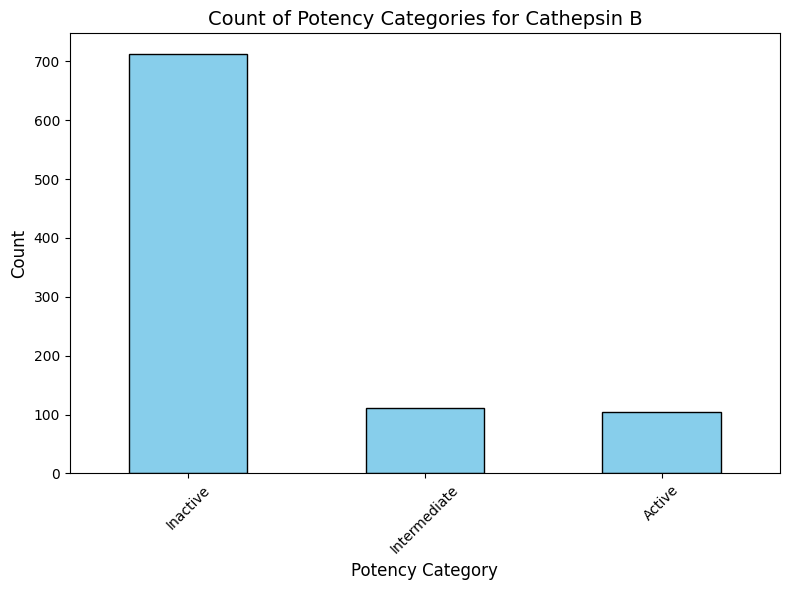

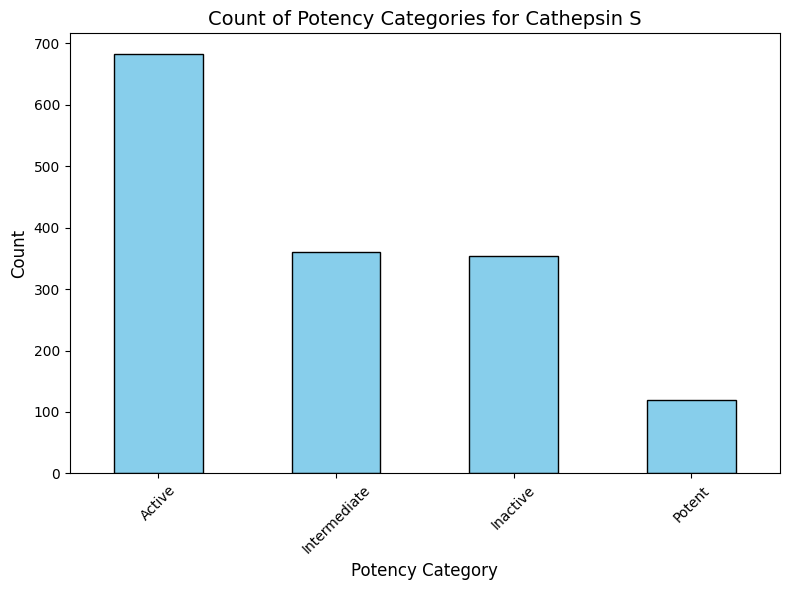

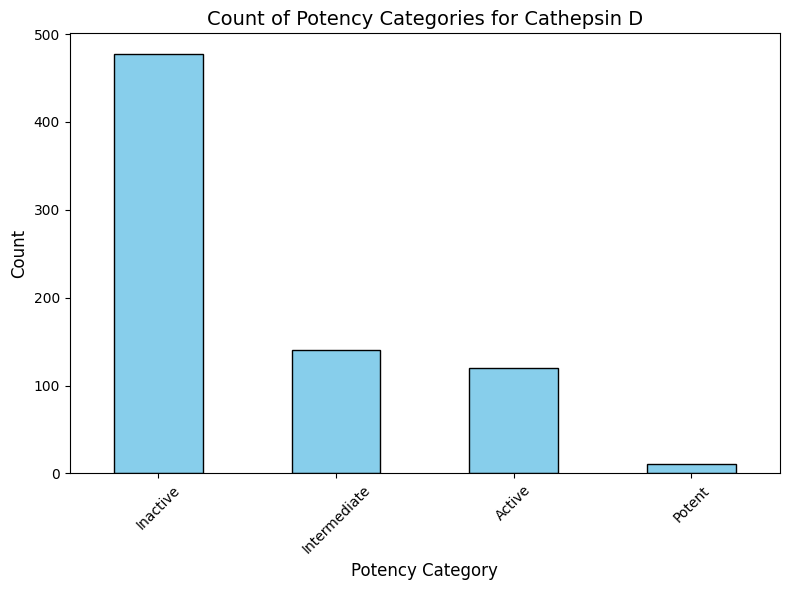

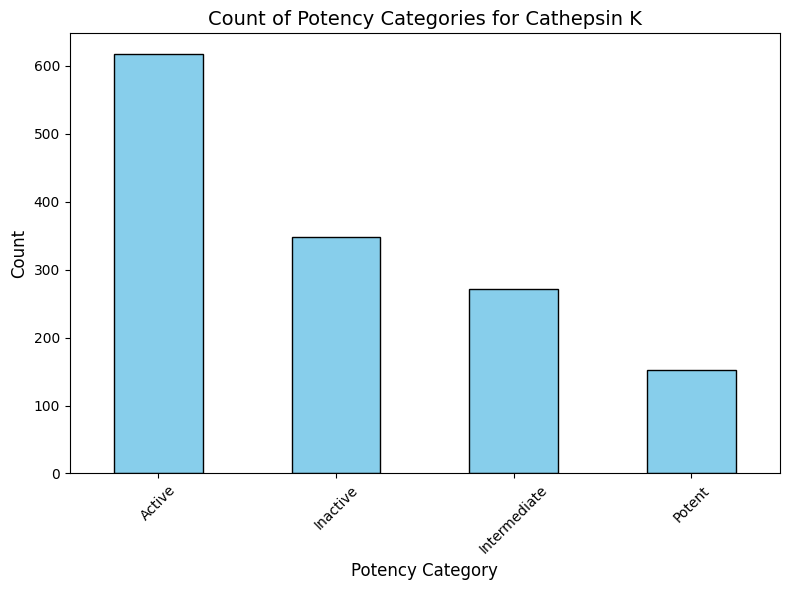

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to categorize based on IC50 values (output as potency categories)
def categorize_potency(ic50):
    if ic50 < 1:
        return "Potent"
    elif 1 <= ic50 < 100:
        return "Active"
    elif 100 <= ic50 < 1000:
        return "Intermediate"
    elif ic50 >= 1000:
        return "Inactive"
    else:
        return "Unknown"


for cat in cathepsins:

    input_file = f"./Intermediate_chEMBL/CAT {cat}/final_chembl_{cat}.tsv"  # Replace with your input TSV file path

    df = pd.read_csv(input_file, sep='\t')

    # Add Potency column based on IC50 values
    df['Potency'] = df['IC50 (nM)'].apply(lambda x: categorize_potency(float(x)))

    # Count the occurrences of each category
    potency_counts = df['Potency'].value_counts()

    # Plotting the count of potency categories
    plt.figure(figsize=(8, 6))
    potency_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Count of Potency Categories for Cathepsin {cat}', fontsize=14)
    plt.xlabel('Potency Category', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
